In [5]:
# -----------------------------------------------------------------------------
# 1. LIBRERÍAS E IMPORTACIÓN
# -----------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

# !pip install pmdarima
from pmdarima import auto_arima

# Cargar (recupera el índice y tipos automáticamente)
df_final = pd.read_pickle('dataset_tesis_final.pkl')
print("✅ Dataset cargado. Dimensiones:", df_final.shape)

# Configuración de gráficos
plt.style.use('seaborn-v0_8-darkgrid')

# -----------------------------------------------------------------------------
# 2. ANÁLISIS DE ESTACIONARIEDAD (ADF Test)
# -----------------------------------------------------------------------------
def test_stationarity(timeseries, title):
    print(f"\nResultados del Test de Dickey-Fuller para: {title}")
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    
    print(dfoutput)
    
    if dfoutput['p-value'] < 0.05:
        print("✅ CONCLUSIÓN: La serie es ESTACIONARIA (Podemos usarla directamente).")
    else:
        print("⚠️ CONCLUSIÓN: La serie NO es estacionaria (Tiene tendencia/media variable). Requiere Diferenciación (d=1).")

# Probamos con la serie original del EMBI
test_stationarity(df_final['target_embi'], "EMBI Nivel (Puntos)")


✅ Dataset cargado. Dimensiones: (4486, 21)

Resultados del Test de Dickey-Fuller para: EMBI Nivel (Puntos)
Test Statistic                   -4.843280
p-value                           0.000045
#Lags Used                       28.000000
Number of Observations Used    4457.000000
Critical Value (1%)              -3.431818
Critical Value (5%)              -2.862189
Critical Value (10%)             -2.567115
dtype: float64
✅ CONCLUSIÓN: La serie es ESTACIONARIA (Podemos usarla directamente).


Entrenamiento: 2008-02-14 00:00:00 -> 2022-05-23 00:00:00 (3588 días)
Prueba (Hold-out): 2022-05-24 00:00:00 -> 2025-12-30 00:00:00 (898 días)


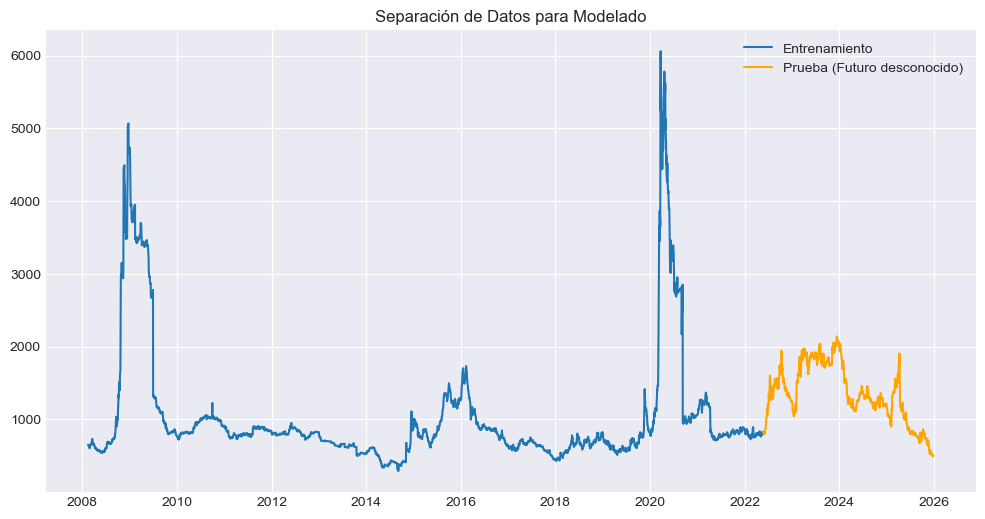


⏳ Buscando los mejores parámetros ARIMA (esto puede tardar unos minutos)...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=41590.105, Time=1.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41603.740, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41593.191, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41594.932, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41601.741, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=41565.143, Time=2.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=41574.784, Time=0.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=41529.976, Time=3.98 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=41555.845, Time=0.40 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=41530.915, Time=4.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=41475.603, Time=6.55 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=41558.889, Time=3.43 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=41529.435, Time=9.07 sec
 ARIMA(3,

In [14]:
# -----------------------------------------------------------------------------
# 3. SPLIT TRAIN / TEST (CRONOLÓGICO)
# -----------------------------------------------------------------------------
# Dejaremos el último 20% para test
train_size = int(len(df_final) * 0.8)
train_data, test_data = df_final.iloc[:train_size], df_final.iloc[train_size:]

print(f"Entrenamiento: {train_data.index.min()} -> {train_data.index.max()} ({len(train_data)} días)")
print(f"Prueba (Hold-out): {test_data.index.min()} -> {test_data.index.max()} ({len(test_data)} días)")

# Visualización del corte
plt.figure(figsize=(12, 6))
plt.plot(train_data['target_embi'], label='Entrenamiento')
plt.plot(test_data['target_embi'], label='Prueba (Futuro desconocido)', color='orange')
plt.title("Separación de Datos para Modelado")
plt.legend()
plt.show()

# -----------------------------------------------------------------------------
# 4. MODELADO BASELINE: AUTO-ARIMA
# -----------------------------------------------------------------------------
print("\n⏳ Buscando los mejores parámetros ARIMA (esto puede tardar unos minutos)...")

# auto_arima prueba múltiples combinaciones de p,d,q y escoge la de menor AIC
model_arima = auto_arima(train_data['target_embi'],
                         start_p=1, start_q=1,
                         max_p=5, max_q=5,
                         m=1,              # Frecuencia estacional (1 = sin estacionalidad compleja diaria)
                         d=None,           # Dejar que el modelo determine si diferenciar
                         seasonal=False,   # Empezamos sin estacionalidad anual para no complicar
                         stepwise=True,
                         trace=True,       # Para ver el progreso
                         error_action='ignore',  
                         suppress_warnings=True)

print(f"\n🏆 Mejor Modelo encontrado: {model_arima.summary()}")

c:\Users\danny\anaconda3\envs\tesis_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\danny\anaconda3\envs\tesis_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



📊 RESULTADOS BASELINE (ARIMA):
RMSE (Error Cuadrático Medio): 674.87 puntos básicos
MAE (Error Absoluto Medio): 572.04 puntos básicos


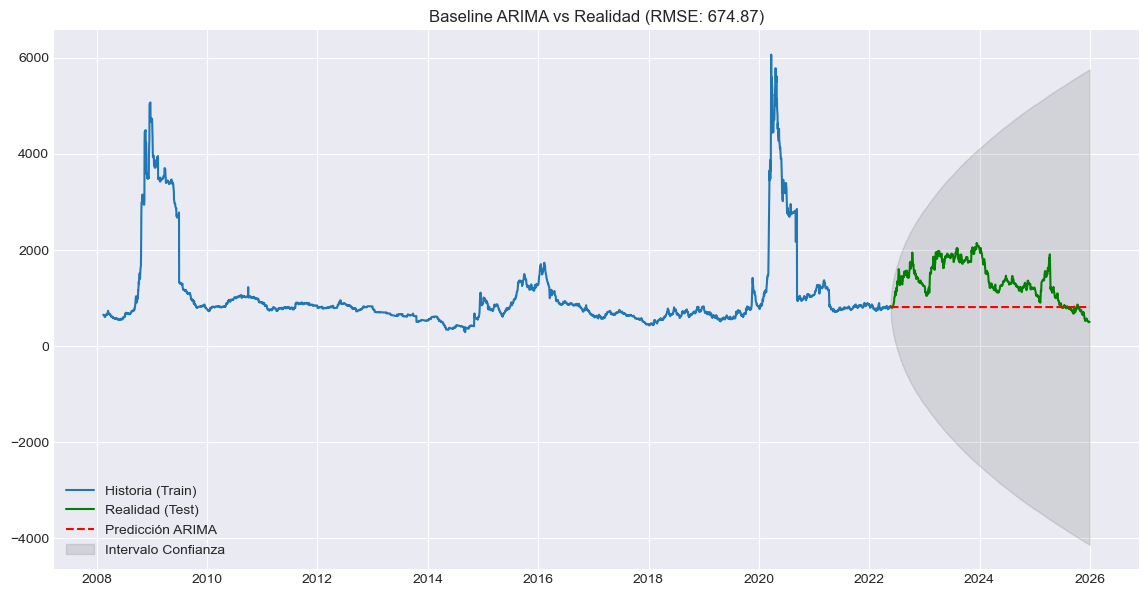

In [15]:
# -----------------------------------------------------------------------------
# 5. PREDICCIÓN Y EVALUACIÓN
# -----------------------------------------------------------------------------
# Predecimos sobre el conjunto de test
prediction, conf_int = model_arima.predict(n_periods=len(test_data), return_conf_int=True)

# CORRECCIÓN AQUÍ:
# Verificamos si 'prediction' es una Serie y extraemos solo sus valores (.values)
# para evitar que Pandas intente alinear índices incompatibles.
if isinstance(prediction, pd.Series):
    pred_values = prediction.values
else:
    pred_values = prediction

# Creamos la serie final asegurando que los valores encajen con las fechas de test
prediction_series = pd.Series(pred_values, index=test_data.index)
lower_series = pd.Series(conf_int[:, 0], index=test_data.index)
upper_series = pd.Series(conf_int[:, 1], index=test_data.index)

# Verificación de seguridad antes de calcular error
if prediction_series.isna().sum() > 0:
    print("⚠️ ADVERTENCIA: Se detectaron NaNs en la predicción. Rellenando con ffill...")
    prediction_series = prediction_series.fillna(method='ffill')

# Métricas de Error
rmse_arima = np.sqrt(mean_squared_error(test_data['target_embi'], prediction_series))
mae_arima = mean_absolute_error(test_data['target_embi'], prediction_series)

print(f"\n📊 RESULTADOS BASELINE (ARIMA):")
print(f"RMSE (Error Cuadrático Medio): {rmse_arima:.2f} puntos básicos")
print(f"MAE (Error Absoluto Medio): {mae_arima:.2f} puntos básicos")

# Gráfico Final del Baseline
plt.figure(figsize=(14, 7))
plt.plot(train_data['target_embi'], label='Historia (Train)')
plt.plot(test_data['target_embi'], label='Realidad (Test)', color='green')
plt.plot(prediction_series, label='Predicción ARIMA', color='red', linestyle='--')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10, label='Intervalo Confianza')
plt.title(f"Baseline ARIMA vs Realidad (RMSE: {rmse_arima:.2f})")
plt.legend()
plt.show()

## Los resultados del modelo Baseline (ARIMA) arrojan un RMSE de 674.87, lo cual demuestra la dificultad que tienen los modelos lineales univariados para capturar la dinámica del Riesgo Paí.